In [1]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 2.4 MB/s eta 0:00:00a 0:00:01m


In [2]:
import os
import numpy as np
import cv2
from pycocotools.coco import COCO
from skimage.draw import polygon
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Set the directory paths
train_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train'
test_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test'
val_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid'

train_annotation_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json'
test_annotation_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/_annotations.coco.json'
val_annotation_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json'


# Load COCO annotations
coco_train = COCO(train_annotation_file)
coco_test = COCO(test_annotation_file)
coco_val = COCO(val_annotation_file)

In [2]:
# Function to create binary masks from COCO annotations
def create_mask(image_id, coco, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)
    for annotation in annotations:
        for seg in annotation['segmentation']:
            poly = np.array(seg).reshape((int(len(seg) / 2), 2))
            rr, cc = polygon(poly[:, 1], poly[:, 0], (height, width))
            mask[rr, cc] = 1
    return mask

# Function to load images and masks
def load_images_and_masks(data_dir, coco, img_height=256, img_width=256):
    image_list = []
    mask_list = []
    img_ids = coco.getImgIds()
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(data_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize to [0, 1]
            mask = create_mask(img_id, coco, img_info['height'], img_info['width'])
            mask = cv2.resize(mask, (img_width, img_height))
            mask = np.expand_dims(mask, axis=-1)
            image_list.append(img)
            mask_list.append(mask)
    return np.array(image_list), np.array(mask_list)

In [2]:
# Load datasets
X_train, Y_train = load_images_and_masks(train_dir, coco_train)
X_val, Y_val = load_images_and_masks(val_dir, coco_val)
X_test, Y_test = load_images_and_masks(test_dir, coco_test)

# Ensure masks are binary
Y_train[Y_train > 0.5] = 1
Y_train[Y_train <= 0.5] = 0

Y_val[Y_val > 0.5] = 1
Y_val[Y_val <= 0.5] = 0

Y_test[Y_test > 0.5] = 1
Y_test[Y_test <= 0.5] = 0

In [2]:
# Define the U-Net model
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = Conv2D(512, (2, 2), activation='relu', padding='same')(u6)
    merge6 = concatenate([c4, u6], axis=3)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = Conv2D(256, (2, 2), activation='relu', padding='same')(u7)
    merge7 = concatenate([c3, u7], axis=3)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = Conv2D(128, (2, 2), activation='relu', padding='same')(u8)
    merge8 = concatenate([c2, u8], axis=3)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = Conv2D(64, (2, 2), activation='relu', padding='same')(u9)
    merge9 = concatenate([c1, u9], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = Conv2D(2, (3, 3), activation='relu', padding='same')(c9)
    c9 = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=inputs, outputs=c9)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [2]:
# Instantiate and train the U-Net model
model = unet_model(input_size=(256, 256, 3))

# Model Checkpointing
checkpoint = ModelCheckpoint('unet_tumor_segmentation.keras', verbose=1, save_best_only=True)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                    batch_size=16, epochs=5, callbacks=[checkpoint, early_stop])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2024-08-21 07:30:41.745267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 07:30:41.745383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 07:30:41.913813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Epoch 1/5


2024-08-21 07:33:44.410380: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-21 07:33:45.452415: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.042220159s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-21 07:33:48.099294: E external/

93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.9030 - loss: 0.3579

2024-08-21 07:38:15.816058: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,64,256,256]{3,2,1,0}, f32[14,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-21 07:38:16.779409: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.963455617s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,64,256,256]{3,2,1,0}, f32[14,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-21 07:38:19.298442: E external/

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9035 - loss: 0.3563   
Epoch 1: val_loss improved from inf to 0.15172, saving model to unet_tumor_segmentation.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 529s 4s/step - accuracy: 0.9040 - loss: 0.3548 - val_accuracy: 0.9633 - val_loss: 0.1517
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.9642 - loss: 0.1218
Epoch 2: val_loss improved from 0.15172 to 0.14628, saving model to unet_tumor_segmentation.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9642 - loss: 0.1218 - val_accuracy: 0.9633 - val_loss: 0.1463
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.9631 - loss: 0.1157
Epoch 3: val_loss improved from 0.14628 to 0.13947, saving model to unet_tumor_segmentation.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9631 - loss: 0.1157 - val_accuracy: 0.9633 - val_loss: 0.1395
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.9641 - loss: 0.1101
Epoch 4: val_loss improved from 0.

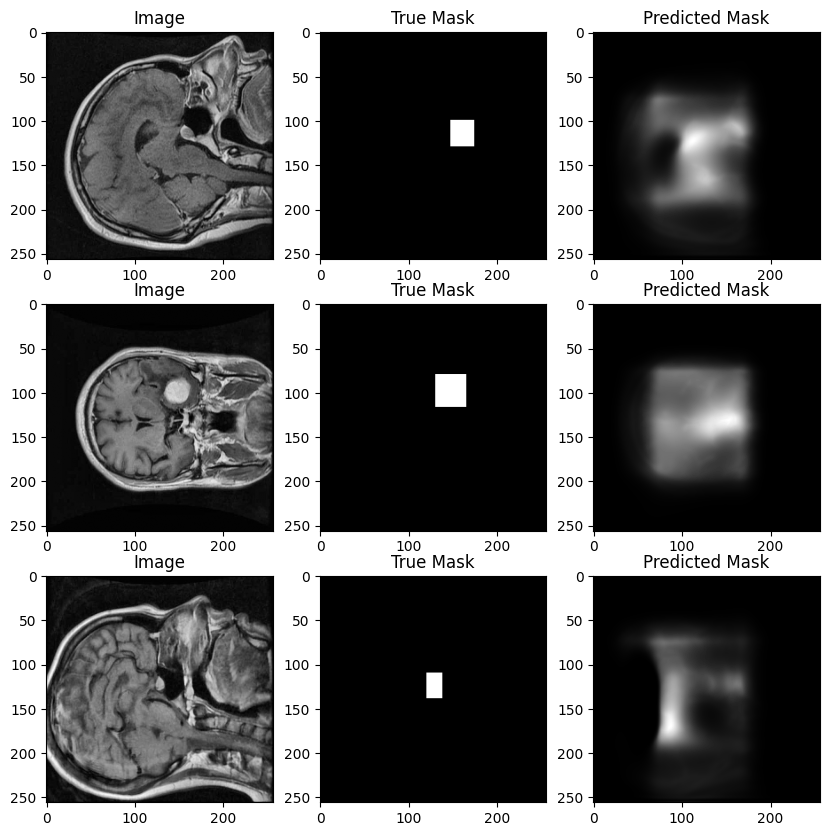

In [2]:
# Plot a few predictions
def plot_sample_predictions(model, X_test, Y_test, num_samples=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        index = np.random.randint(0, len(X_test))
        image = X_test[index]
        true_mask = Y_test[index]
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
        
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("True Mask")
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
    
    plt.show()

# Visualize predictions
plot_sample_predictions(model, X_test, Y_test)